# Perturbed satellite orbit
## Objectives
This example demonstrates the propagation of a (quasi-massless) body dominated by a central point-mass attractor, but also including multiple perturbing accelerations exerted by the central body as well as third bodies.

The example showcases the ease with which a simulation environment can be extended to a multi-body system. It also demonstrates the wide variety of acceleration types that can be modelled using the `propagation_setup.acceleration` module, including accelerations from non-conservative forces such as drag and radiation pressure. Note that the modelling of these acceleration types requires special environment interfaces (implemented via [AerodynamicCoefficientSettings](https://py.api.tudat.space/en/latest/aerodynamic_coefficients.html#tudatpy.numerical_simulation.environment_setup.aerodynamic_coefficients.AerodynamicCoefficientSettings) and [RadiationPressureTargetModelSettings](https://py.api.tudat.space/en/latest/radiation_pressure.html#tudatpy.numerical_simulation.environment_setup.radiation_pressure.RadiationPressureTargetModelSettings)) of the body undergoing the accelerations.

It also demonstrates and motivates the usage of dependent variables. By keeping track of such variables throughout the propagation, valuable insight, such as contributions of individual acceleration types, ground tracks or the evolution of Kepler elements, can be derived in the post-propagation analysis.

## Import statements
The required import statements are made here, at the very beginning.

Some standard modules are first loaded. These are `numpy` and `matplotlib.pyplot`.

Then, the different modules of `tudatpy` that will be used are imported.

In [1]:
# Load standard modules
import numpy as np

import matplotlib
from matplotlib import pyplot as plt

# Load tudatpy modules
from tudatpy.interface import spice
from tudatpy import numerical_simulation
from tudatpy.numerical_simulation import environment
from tudatpy.numerical_simulation import environment_setup, propagation_setup
from tudatpy.astro import element_conversion
from tudatpy import constants
from tudatpy.util import result2array
from tudatpy.astro.time_conversion import DateTime

## Configuration
NAIF's `SPICE` kernels are first loaded, so that the position of various bodies such as the Earth can be make known to `tudatpy`.
See [SPICE in Tudat](https://docs.tudat.space/en/latest/_src_user_guide/state_propagation/environment_setup/default_env_models.html#spice-in-tudat) for an overview of the use of SPICE in Tudat.

In [2]:
# Load spice kernels
spice.load_standard_kernels()

## Environment setup
Let’s create the environment for our simulation. This setup covers the creation of (celestial) bodies, vehicle(s), and environment interfaces.

For more information on how to create and customize settings, see the [user guide on how to create bodies](https://docs.tudat.space/en/latest/_src_user_guide/state_propagation/environment_setup.html#body-creation-procedure).

### Create the bodies
**Celestial** bodies can be created by making a list of strings with the bodies that is to be included in the simulation.

For the most common celestial bodies in our Solar system, default settings (such as atmosphere, body shape, rotation model) come predefined in Tudat.
See the [user guide on default environment models](https://docs.tudat.space/en/latest/_src_user_guide/state_propagation/environment_setup.html#body-creation-procedure) for a comprehensive list of default models.

These settings can be adjusted. Please refer to the [Available Environment Models](https://docs.tudat.space/en/latest/_src_user_guide/state_propagation/environment_setup/environment_models.html#available-model-types) in the user guide for more details.

In [3]:
# Define string names for bodies to be created from default.
bodies_to_create = ["Sun", "Earth", "Moon", "Mars", "Venus"]

# Use "Earth"/"J2000" as global frame origin and orientation.
global_frame_origin = "Earth"
global_frame_orientation = "J2000"

# Create default body settings
body_settings = environment_setup.get_default_body_settings(
    bodies_to_create,
    global_frame_origin,
    global_frame_orientation)

### Create the vehicle
Let's now create `Delfi-C3`, the satellite for which the perturbed orbit around Earth will be propagated.
Since Delfi-C3 is not a predefined celestial object, no default settings are available and the settings have to be created manually.

In [4]:
# Create empty body settings for the satellite
body_settings.add_empty_settings("Delfi-C3")

To account for the aerodynamic of the satellite, an aerodynamic interface needs to be defined and assigned to Delfi-C3's settings, taking the followings into account:

- A constant drag coefficient of 1.2.
- A reference area of 0.035m $^2$ .
- No sideslip or lift coefficient (equal to 0).
- No moment coefficient.

In [5]:
# Create aerodynamic coefficient interface settings
reference_area_drag = (4*0.3*0.1+2*0.1*0.1)/4  # Average projection area of a 3U CubeSat
drag_coefficient = 1.2
aero_coefficient_settings = environment_setup.aerodynamic_coefficients.constant(
    reference_area_drag, [drag_coefficient, 0.0, 0.0]
)

# Add the aerodynamic interface to the body settings
body_settings.get("Delfi-C3").aerodynamic_coefficient_settings = aero_coefficient_settings

To account for the pressure of the solar radiation on the satellite, let's add another interface. This takes a radiation pressure coefficient of 1.2, and a radiation area of 4m $^2$ . This interface also accounts for the variation in pressure cause by the shadow of Earth.

Note: Since we created the Sun using the default environment settings, the Sun will be assigned an isotropic source model with constant luminosity by default and we do not have to assign radiation source settings to the Sun manually.
However, this can also be adapted to your needs, see [the API reference on radiation pressure](https://py.api.tudat.space/en/latest/radiation_pressure.html) for more information.

In [6]:
# Create radiation pressure settings
reference_area_radiation = (4*0.3*0.1+2*0.1*0.1)/4  # Average projection area of a 3U CubeSat
radiation_pressure_coefficient = 1.2
occulting_bodies_dict = dict()
occulting_bodies_dict["Sun"] = ["Earth"]
vehicle_target_settings = environment_setup.radiation_pressure.cannonball_radiation_target(
    reference_area_radiation, radiation_pressure_coefficient, occulting_bodies_dict )

# Add the radiation pressure interface to the body settings
body_settings.get("Delfi-C3").radiation_pressure_target_settings = vehicle_target_settings

Finally, the system of bodies is created using the settings. This system of bodies is stored into the variable `bodies`.

In [7]:
bodies = environment_setup.create_system_of_bodies(body_settings)
bodies.get("Delfi-C3").mass = 2.2 #kg

## Propagation setup
Now that the environment is created, the propagation setup is defined.

First, the bodies to be propagated and the central bodies will be defined.
Central bodies are the bodies with respect to which the state of the respective propagated bodies is defined.

In [8]:
# Define bodies that are propagated
bodies_to_propagate = ["Delfi-C3"]

# Define central bodies of propagation
central_bodies = ["Earth"]

### Create the acceleration model
First off, the acceleration settings that act on `Delfi-C3` are to be defined.
In this case, these consist in the followings:

- Gravitational acceleration of Earth modeled as Spherical Harmonics, taken up to a degree and order 5.
- Gravitational acceleration of the Sun, the Moon, Mars, and Venus, modeled as a Point Mass.
- Aerodynamic acceleration caused by the atmosphere of the Earth (using the aerodynamic interface defined earlier).
- Radiation pressure acceleration caused by the Sun (using the radiation interface defined earlier).

The acceleration settings defined are then applied to `Delfi-C3` in a dictionary.

This dictionary is finally input to the propagation setup to create the acceleration models.

In [9]:
# Define accelerations acting on Delfi-C3 by Sun and Earth.
accelerations_settings_delfi_c3 = dict(
    Sun=[
        propagation_setup.acceleration.radiation_pressure(),
        propagation_setup.acceleration.point_mass_gravity()
    ],
    Earth=[
        propagation_setup.acceleration.spherical_harmonic_gravity(5, 5),
        propagation_setup.acceleration.aerodynamic()
    ],
    Moon=[
        propagation_setup.acceleration.point_mass_gravity()
    ],
    Mars=[
        propagation_setup.acceleration.point_mass_gravity()
    ],
    Venus=[
        propagation_setup.acceleration.point_mass_gravity()
    ]
)

# Create global accelerations settings dictionary.
acceleration_settings = {"Delfi-C3": accelerations_settings_delfi_c3}

# Create acceleration models.
acceleration_models = propagation_setup.create_acceleration_models(
    bodies,
    acceleration_settings,
    bodies_to_propagate,
    central_bodies)

### Define propagation start and end epochs

Next, the start and end simulation epochs are specified.
In Tudat, all epochs are defined as seconds since J2000.
For ease of use, the start and end epochs are derived from calender dates using the `DateTime` class.
Please refer to the [API documentation](https://py.api.tudat.space/en/latest/time_conversion.html) of the `time_conversion` module for more information on this.

In [10]:
# Set simulation start and end epochs
simulation_start_epoch = DateTime(2008, 4, 28).epoch()
simulation_end_epoch   = DateTime(2008, 4, 29).epoch()

### Define the initial state
The initial state of the vehicle that will be propagated is now defined. 

This initial state always has to be provided as a cartesian state, in the form of a list with the first three elements representing the initial position, and the three remaining elements representing the initial velocity.

Within this example, we will retrieve the initial state of Delfi-C3 using its Two-Line-Elements (TLE) the date of its launch (April the 28th, 2008). The TLE strings are obtained from [space-track.org](https://www.space-track.org).

In [11]:
# Retrieve the initial state of Delfi-C3 using Two-Line-Elements (TLEs)
delfi_tle = environment.Tle(
    "1 32789U 07021G   08119.60740078 -.00000054  00000-0  00000+0 0  9999",
    "2 32789 098.0082 179.6267 0015321 307.2977 051.0656 14.81417433    68",
)
delfi_ephemeris = environment.TleEphemeris("Earth", "J2000", delfi_tle, False)
initial_state = delfi_ephemeris.cartesian_state( simulation_start_epoch )

### Define dependent variables to save
In this example, we are interested in saving not only the propagated state of the satellite over time, but also a set of so-called dependent variables, that are to be computed (or extracted and saved) at each integration step.

[This page](https://py.api.tudat.space/en/latest/dependent_variable.html) of the tudatpy API website provides a detailed explanation of all the dependent variables that are available.

In [12]:
# Define list of dependent variables to save
dependent_variables_to_save = [
    propagation_setup.dependent_variable.total_acceleration("Delfi-C3"),
    propagation_setup.dependent_variable.keplerian_state("Delfi-C3", "Earth"),
    propagation_setup.dependent_variable.latitude("Delfi-C3", "Earth"),
    propagation_setup.dependent_variable.longitude("Delfi-C3", "Earth"),
    propagation_setup.dependent_variable.single_acceleration_norm(
        propagation_setup.acceleration.point_mass_gravity_type, "Delfi-C3", "Sun"
    ),
    propagation_setup.dependent_variable.single_acceleration_norm(
        propagation_setup.acceleration.point_mass_gravity_type, "Delfi-C3", "Moon"
    ),
    propagation_setup.dependent_variable.single_acceleration_norm(
        propagation_setup.acceleration.point_mass_gravity_type, "Delfi-C3", "Mars"
    ),
    propagation_setup.dependent_variable.single_acceleration_norm(
        propagation_setup.acceleration.point_mass_gravity_type, "Delfi-C3", "Venus"
    ),
    propagation_setup.dependent_variable.single_acceleration_norm(
        propagation_setup.acceleration.spherical_harmonic_gravity_type, "Delfi-C3", "Earth"
    ),
    propagation_setup.dependent_variable.single_acceleration_norm(
        propagation_setup.acceleration.aerodynamic_type, "Delfi-C3", "Earth"
    ),
    propagation_setup.dependent_variable.single_acceleration_norm(
        propagation_setup.acceleration.radiation_pressure_type, "Delfi-C3", "Sun"
    )
]

### Create the propagator settings
The propagator is finally setup.

First, a termination condition is defined so that the propagation will stop when the end epochs that was defined is reached.

Subsequently, the integrator settings are defined using a RK4 integrator with the fixed step size of 10 seconds.

Then, the translational propagator settings are defined. These are used to simulate the orbit of `Delfi-C3` around Earth.

In [13]:
# Create termination settings
termination_condition = propagation_setup.propagator.time_termination(simulation_end_epoch)

# Create numerical integrator settings
fixed_step_size = 10.0
integrator_settings = propagation_setup.integrator.runge_kutta_fixed_step(
    fixed_step_size, coefficient_set=propagation_setup.integrator.CoefficientSets.rk_4
)

# Create propagation settings
propagator_settings = propagation_setup.propagator.translational(
    central_bodies,
    acceleration_models,
    bodies_to_propagate,
    initial_state,
    simulation_start_epoch,
    integrator_settings,
    termination_condition,
    output_variables=dependent_variables_to_save
)

## Propagate the orbit
The orbit is now ready to be propagated.

This is done by calling the `create_dynamics_simulator()` function of the `numerical_simulation` module.
This function requires the `bodies` and `propagator_settings` that have all been defined earlier.

After this, the history of the propagated state over time, containing both the position and velocity history, is extracted.
This history, taking the form of a dictionary, is then converted to an array containing 7 columns:

- Column 0: Time history, in seconds since J2000.
- Columns 1 to 3: Position history, in meters, in the frame that was specified in the `body_settings`.
- Columns 4 to 6: Velocity history, in meters per second, in the frame that was specified in the `body_settings`.

The same is done with the dependent variable history. The column indexes corresponding to a given dependent variable in the `dep_vars` variable are printed when the simulation is run, when `create_dynamics_simulator()` is called.
Do mind that converting to an ndarray using the `result2array()` utility will shift these indexes, since the first column (index 0) will then be the times.

In [14]:
# Create simulation object and propagate the dynamics
dynamics_simulator = numerical_simulation.create_dynamics_simulator(
    bodies, propagator_settings
)

# Extract the resulting state and dependent variable history and convert it to an ndarray
states = dynamics_simulator.propagation_results.state_history
states_array = result2array(states)
dep_vars = dynamics_simulator.propagation_results.dependent_variable_history
dep_vars_array = result2array(dep_vars)

## Post-process the propagation results
The results of the propagation are then processed to a more user-friendly form.

### Total acceleration over time
Let's first plot the total acceleration on the satellite over time. This can be done by taking the norm of the first three columns of the dependent variable list.

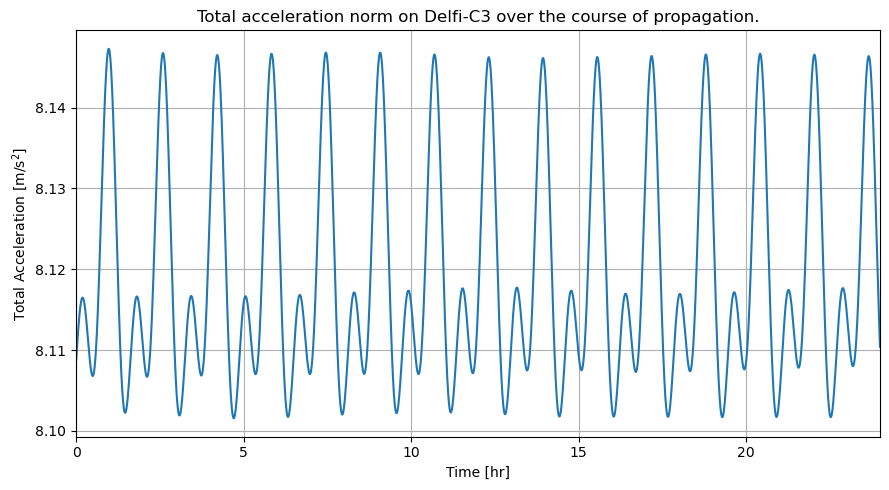

In [15]:
# Plot total acceleration as function of time
time_hours = (dep_vars_array[:,0] - dep_vars_array[0,0])/3600
total_acceleration_norm = np.linalg.norm(dep_vars_array[:,1:4], axis=1)
plt.figure(figsize=(9, 5))
plt.title("Total acceleration norm on Delfi-C3 over the course of propagation.")
plt.plot(time_hours, total_acceleration_norm)
plt.xlabel('Time [hr]')
plt.ylabel('Total Acceleration [m/s$^2$]')
plt.xlim([min(time_hours), max(time_hours)])
plt.grid()
plt.tight_layout()

### Ground track
Let's then plot the ground track of the satellite in its first 3 hours. This makes use of the latitude and longitude dependent variables.

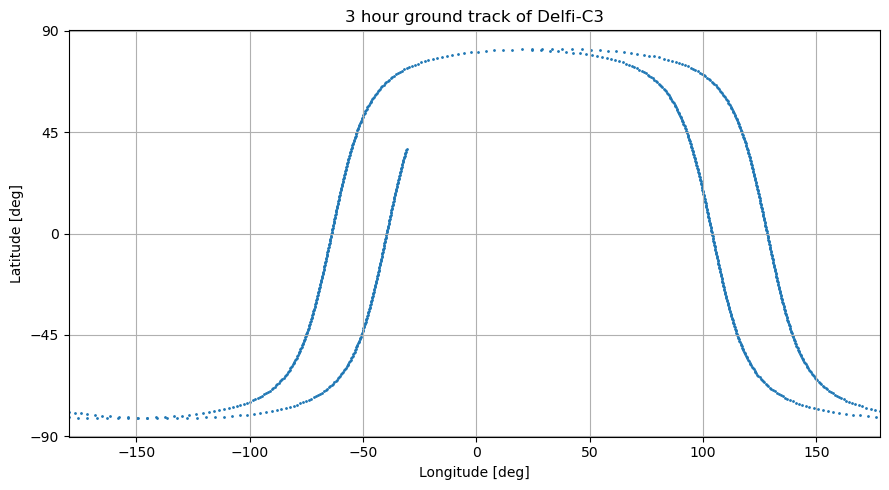

In [16]:
# Plot ground track for a period of 3 hours
latitude = dep_vars_array[:,10]
longitude = dep_vars_array[:,11]
hours = 3
subset = int(len(time_hours) / 24 * hours)
latitude = np.rad2deg(latitude[0: subset])
longitude = np.rad2deg(longitude[0: subset])
plt.figure(figsize=(9, 5))
plt.title("3 hour ground track of Delfi-C3")
plt.scatter(longitude, latitude, s=1)
plt.xlabel('Longitude [deg]')
plt.ylabel('Latitude [deg]')
plt.xlim([min(longitude), max(longitude)])
plt.yticks(np.arange(-90, 91, step=45))
plt.grid()
plt.tight_layout()

### Kepler elements over time
Let's now plot each of the 6 Kepler element as a function of time, also as saved in the dependent variables.

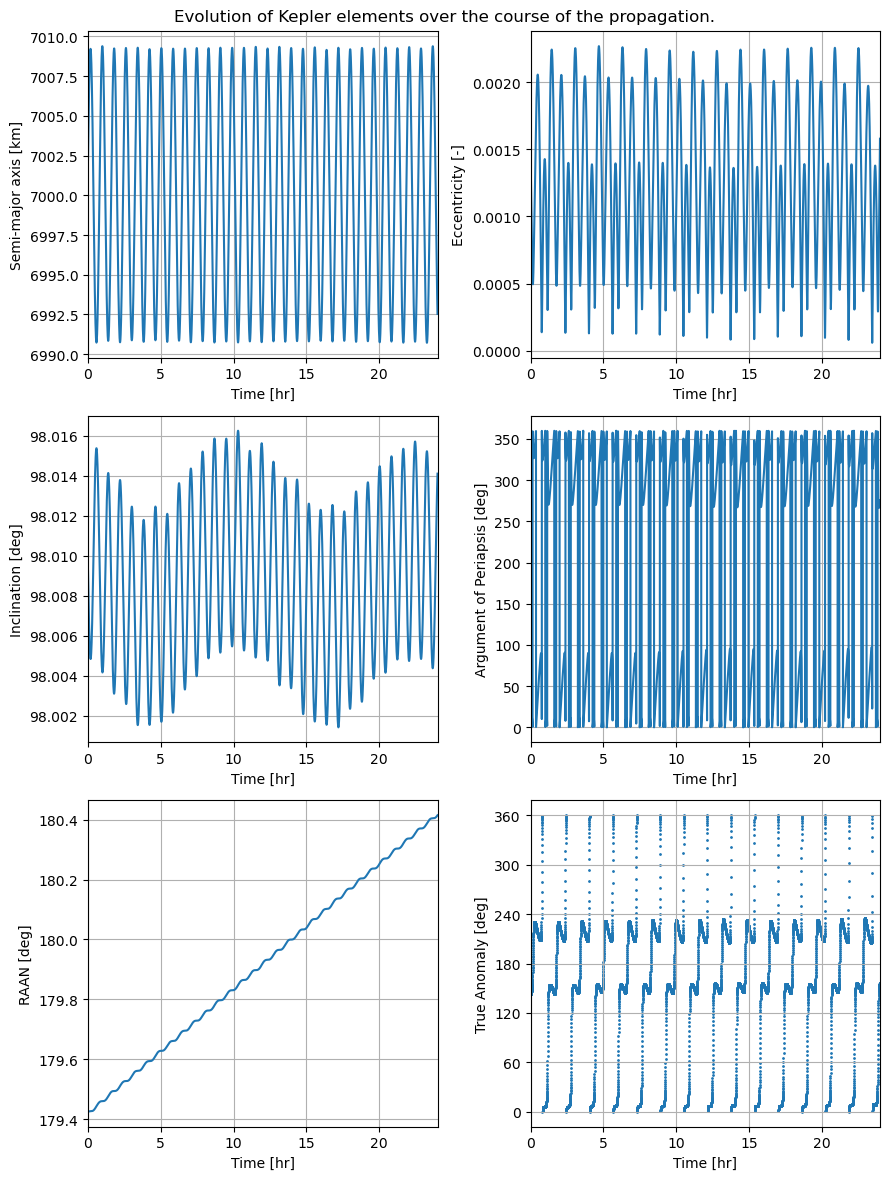

In [17]:
# Plot Kepler elements as a function of time
kepler_elements = dep_vars_array[:,4:10]
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(9, 12))
fig.suptitle('Evolution of Kepler elements over the course of the propagation.')

# Semi-major Axis
semi_major_axis = kepler_elements[:,0] / 1e3
ax1.plot(time_hours, semi_major_axis)
ax1.set_ylabel('Semi-major axis [km]')

# Eccentricity
eccentricity = kepler_elements[:,1]
ax2.plot(time_hours, eccentricity)
ax2.set_ylabel('Eccentricity [-]')

# Inclination
inclination = np.rad2deg(kepler_elements[:,2])
ax3.plot(time_hours, inclination)
ax3.set_ylabel('Inclination [deg]')

# Argument of Periapsis
argument_of_periapsis = np.rad2deg(kepler_elements[:,3])
ax4.plot(time_hours, argument_of_periapsis)
ax4.set_ylabel('Argument of Periapsis [deg]')

# Right Ascension of the Ascending Node
raan = np.rad2deg(kepler_elements[:,4])
ax5.plot(time_hours, raan)
ax5.set_ylabel('RAAN [deg]')

# True Anomaly
true_anomaly = np.rad2deg(kepler_elements[:,5])
ax6.scatter(time_hours, true_anomaly, s=1)
ax6.set_ylabel('True Anomaly [deg]')
ax6.set_yticks(np.arange(0, 361, step=60))

for ax in fig.get_axes():
    ax.set_xlabel('Time [hr]')
    ax.set_xlim([min(time_hours), max(time_hours)])
    ax.grid()
plt.tight_layout()

### Accelerations over time
Finally, let's plot and compare each of the included accelerations.

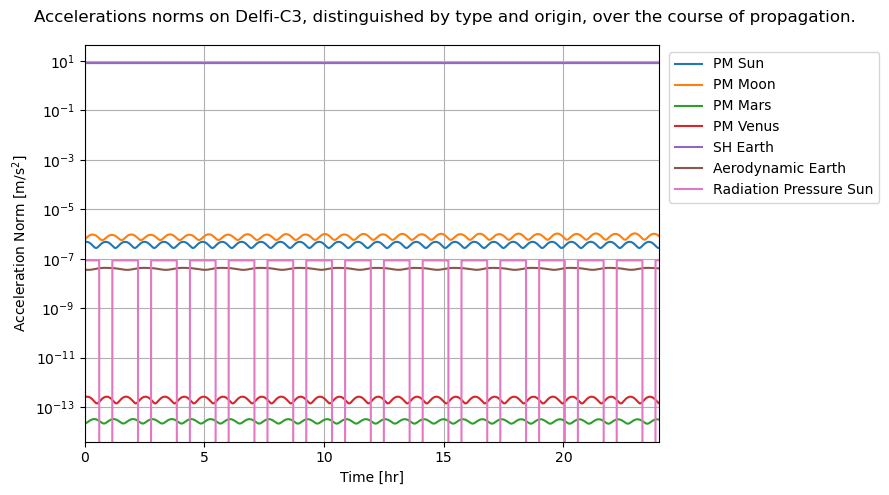

In [18]:
plt.figure(figsize=(9, 5))

# Point Mass Gravity Acceleration Sun
acceleration_norm_pm_sun = dep_vars_array[:,12]
plt.plot(time_hours, acceleration_norm_pm_sun, label='PM Sun')

# Point Mass Gravity Acceleration Moon
acceleration_norm_pm_moon = dep_vars_array[:,13]
plt.plot(time_hours, acceleration_norm_pm_moon, label='PM Moon')

# Point Mass Gravity Acceleration Mars
acceleration_norm_pm_mars = dep_vars_array[:,14]
plt.plot(time_hours, acceleration_norm_pm_mars, label='PM Mars')

# Point Mass Gravity Acceleration Venus
acceleration_norm_pm_venus = dep_vars_array[:,15]
plt.plot(time_hours, acceleration_norm_pm_venus, label='PM Venus')

# Spherical Harmonic Gravity Acceleration Earth
acceleration_norm_sh_earth = dep_vars_array[:,16]
plt.plot(time_hours, acceleration_norm_sh_earth, label='SH Earth')

# Aerodynamic Acceleration Earth
acceleration_norm_aero_earth = dep_vars_array[:,17]
plt.plot(time_hours, acceleration_norm_aero_earth, label='Aerodynamic Earth')

# Cannonball Radiation Pressure Acceleration Sun
acceleration_norm_rp_sun = dep_vars_array[:,18]
plt.plot(time_hours, acceleration_norm_rp_sun, label='Radiation Pressure Sun')

plt.xlim([min(time_hours), max(time_hours)])
plt.xlabel('Time [hr]')
plt.ylabel('Acceleration Norm [m/s$^2$]')

plt.legend(bbox_to_anchor=(1.005, 1))
plt.suptitle("Accelerations norms on Delfi-C3, distinguished by type and origin, over the course of propagation.")
plt.yscale('log')
plt.grid()
plt.tight_layout()